In [15]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from transformers import AlbertTokenizer, AlbertForSequenceClassification, DataCollatorWithPadding
from torch.optim import AdamW
from torch.utils.data import DataLoader
from datasets import Dataset
import torch

In [2]:
data = pd.read_csv('albert_data.csv')
data.head()

,Query,Label
0,Заголовок статьи,Нерелевантный запрос
1,Подписание контракта после отказа от заключени...,Вопросы по базе знаний
2,Участие в котировочной сессии,Вопросы по базе знаний
3,Страница контракта организации,Вопросы по базе знаний
4,Определение победителя и заключение контракта ...,Вопросы по базе знаний


In [3]:
print(data.columns)
data.columns = list(map(str.lower, data.columns))
data.columns

Index(['Query', 'Label'], dtype='object')


Index(['query', 'label'], dtype='object')

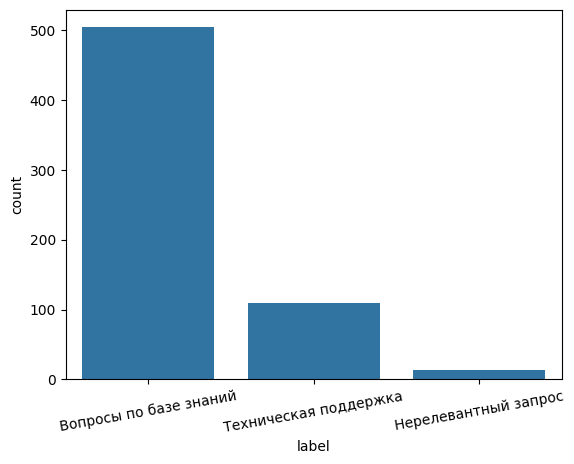

In [4]:
unique_values = data.label.value_counts()
plt.xticks(rotation=10)
sns.barplot(unique_values);

In [5]:
data[data.label == 'Нерелевантный запрос']

,query,label
0,Заголовок статьи,Нерелевантный запрос
118,Видео,Нерелевантный запрос
134,Карта сайта,Нерелевантный запрос
156,Вопросы и ответы,Нерелевантный запрос
268,Карта сайта,Нерелевантный запрос
372,Тестовая статья,Нерелевантный запрос
390,Карта сайта,Нерелевантный запрос
459,Новая статья про котировочные сессии 1,Нерелевантный запрос
464,тест знания,Нерелевантный запрос
465,тест знания,Нерелевантный запрос


Бд я посмотрел, там в целом +- норм разметка

In [6]:
albert_tokenizer = AlbertTokenizer.from_pretrained("albert-base-v2")
albert_model = AlbertForSequenceClassification.from_pretrained("albert-base-v2", num_labels=len(unique_values))
print(f'num_classes: {len(unique_values)}')

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


num_classes: 3


In [7]:
for i, row in enumerate(unique_values.index):
    print(f'{i} - {row}')

0 - Вопросы по базе знаний
1 - Техническая поддержка
2 - Нерелевантный запрос


In [8]:
convert_dict = {
    'Вопросы по базе знаний' : 0,
    'Техническая поддержка' : 1,
    'Нерелевантный запрос' : 2
}

In [9]:
data['label_id'] = data.label.apply(lambda row: convert_dict[row])
data.head()

,query,label,label_id
0,Заголовок статьи,Нерелевантный запрос,2
1,Подписание контракта после отказа от заключени...,Вопросы по базе знаний,0
2,Участие в котировочной сессии,Вопросы по базе знаний,0
3,Страница контракта организации,Вопросы по базе знаний,0
4,Определение победителя и заключение контракта ...,Вопросы по базе знаний,0


In [13]:
def tokenize_function(examples):
    # Tokenize the 'query' column, truncate to max_length=128, no padding here
    return albert_tokenizer(examples['query'], truncation=True, max_length=128)

In [16]:
dataset = Dataset.from_pandas(data)

In [17]:
tokenized_dataset = dataset.map(tokenize_function, batched=True)
tokenized_dataset

Map:   0%|          | 0/627 [00:00<?, ? examples/s]

Map: 100%|██████████| 627/627 [00:00<00:00, 3710.96 examples/s]


Dataset({
    features: ['query', 'label', 'label_id', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 627
})

In [18]:
# Step 4: Rename 'label_id' to 'labels' for the Trainer
tokenized_dataset = tokenized_dataset.rename_column('label_id', 'labels')
tokenized_dataset = tokenized_dataset.rename_column('label', 'label_decoded')
tokenized_dataset

Dataset({
    features: ['query', 'label_decoded', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 627
})

In [19]:
tokenized_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
tokenized_dataset

Dataset({
    features: ['query', 'label_decoded', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 627
})

In [20]:
train_test = tokenized_dataset.train_test_split(test_size=0.2)
train_dataset = train_test['train']
eval_dataset = train_test['test']

In [21]:
# Create DataLoaders with dynamic padding
data_collator = DataCollatorWithPadding(albert_tokenizer)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=data_collator)
eval_dataloader = DataLoader(eval_dataset, batch_size=16, collate_fn=data_collator)

In [22]:
train_dataloader.dataset, eval_dataloader.dataset

(Dataset({
     features: ['query', 'label_decoded', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
     num_rows: 501
 }),
 Dataset({
     features: ['query', 'label_decoded', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
     num_rows: 126
 }))

In [23]:
# Set up the optimizer and device
optimizer = AdamW(albert_model.parameters(), lr=2e-5)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
albert_model.to(device);

In [27]:
# Training loop
num_epochs = 15
for epoch in range(num_epochs):
    # Training phase
    albert_model.train()
    total_train_loss = 0
    for batch in train_dataloader:
        # Move batch to device
        batch = {k: v.to(device) for k, v in batch.items()}
        # Forward pass
        outputs = albert_model(**batch)
        loss = outputs.loss
        total_train_loss += loss.item()
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Compute and print average training loss
    avg_train_loss = total_train_loss / len(train_dataloader)
    print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}')

    # Evaluation phase
    albert_model.eval()
    total_eval_accuracy = 0
    for batch in eval_dataloader:
        # Move batch to device
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            # Forward pass
            outputs = albert_model(**batch)
            logits = outputs.logits
            # Compute predictions
            predictions = torch.argmax(logits, dim=-1)
            labels = batch['labels']
            # Calculate accuracy
            accuracy = (predictions == labels).float().mean()
            total_eval_accuracy += accuracy.item()
    
    # Compute and print average evaluation accuracy
    avg_eval_accuracy = total_eval_accuracy / len(eval_dataloader)
    print(f'Epoch {epoch+1}, Eval Accuracy: {avg_eval_accuracy:.4f}')

Epoch 1, Train Loss: 0.4838
Epoch 1, Eval Accuracy: 0.7902
Epoch 2, Train Loss: 0.5009
Epoch 2, Eval Accuracy: 0.8069
Epoch 3, Train Loss: 0.4601
Epoch 3, Eval Accuracy: 0.8080
Epoch 4, Train Loss: 0.5026
Epoch 4, Eval Accuracy: 0.8080
Epoch 5, Train Loss: 0.4792
Epoch 5, Eval Accuracy: 0.8158
Epoch 6, Train Loss: 0.4671
Epoch 6, Eval Accuracy: 0.7902
Epoch 7, Train Loss: 0.4783
Epoch 7, Eval Accuracy: 0.8315
Epoch 8, Train Loss: 0.4580
Epoch 8, Eval Accuracy: 0.8002
Epoch 9, Train Loss: 0.4624
Epoch 9, Eval Accuracy: 0.7846
Epoch 10, Train Loss: 0.4340
Epoch 10, Eval Accuracy: 0.8158
Epoch 11, Train Loss: 0.4135
Epoch 11, Eval Accuracy: 0.7388
Epoch 12, Train Loss: 0.4085
Epoch 12, Eval Accuracy: 0.8315
Epoch 13, Train Loss: 0.3931
Epoch 13, Eval Accuracy: 0.8315
Epoch 14, Train Loss: 0.3953
Epoch 14, Eval Accuracy: 0.8158
Epoch 15, Train Loss: 0.4041
Epoch 15, Eval Accuracy: 0.8080


In [28]:
# After the training loop
save_directory = "./albert_finetuned"
albert_model.save_pretrained(save_directory)
albert_tokenizer.save_pretrained(save_directory)

('./albert_finetuned/tokenizer_config.json',
 './albert_finetuned/special_tokens_map.json',
 './albert_finetuned/spiece.model',
 './albert_finetuned/added_tokens.json')

In [29]:
from transformers import AlbertForSequenceClassification, AlbertTokenizer

# Load the model and tokenizer
model = AlbertForSequenceClassification.from_pretrained(save_directory)
tokenizer = AlbertTokenizer.from_pretrained(save_directory)

In [30]:
data.to_csv('albert_data_formatted.csv')